In [1]:
# Authenticate user for Hugging Face Hub
from huggingface_hub import notebook_login
notebook_login()

In [2]:
# Import necessary libraries for tokenizer, model, and training
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer
from datasets import load_dataset
from sklearnex import patch_sklearn
import matplotlib.pyplot as plt  # Import Matplotlib for plotting

# Apply Intel optimizations for scikit-learn with oneAPI
patch_sklearn()

import numpy as np


# Initialize tokenizer and model for the T5 transformer
model_name = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [3]:
# Load dataset for training from a CSV file
data_path = "/kaggle/input/job-description-dataset/job_descriptions.csv"
dataset = load_dataset("csv", data_files=data_path)

# Prepare dataset for splitting into training and validation sets
dataset_split = dataset["train"].train_test_split(test_size=2000, train_size=30000, seed=42)
train_data = dataset_split["train"]
valid_data = dataset_split["test"]

Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
# Preprocess the data to convert text into tokenized form
def preprocess(examples):
    inputs = tokenizer(examples["Job Description"], padding="max_length", truncation=True, max_length=64)
    labels = tokenizer(examples["skills"], padding="max_length", truncation=True, max_length=64)
    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "labels": labels["input_ids"]
    }

# Apply the preprocessing function to both training and validation datasets
train_data = train_data.map(preprocess, batched=True)
valid_data = valid_data.map(preprocess, batched=True)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [5]:
# Define training arguments like output path, batch size, and number of epochs
training_args = TrainingArguments(
    output_dir="./model_outputs",
    per_device_train_batch_size=25,
    save_steps=500,
    num_train_epochs=2,
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=500,
    logging_dir="./training_logs",
    push_to_hub=False,  # Disable push to Hub for simplicity
    report_to="none"  # Disable logging to Hugging Face Hub for simplicity
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [6]:
# Initialize lists to collect loss values
train_losses = []
eval_losses = []

In [7]:
# Import necessary libraries for tokenizer, model, and training
from transformers import TrainerCallback

# Custom callback to capture training and evaluation losses
class CustomCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                train_losses.append(logs["loss"])
            if "eval_loss" in logs:
                eval_losses.append(logs["eval_loss"])

                
# Create a Trainer instance to train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=valid_data,
)

# Train the model with the custom callback
trainer.add_callback(CustomCallback())
trainer.train()


# Save the trained model for later use
trainer.save_model("./final_model")

tokenizer.save_pretrained("./final_model")


Step,Training Loss,Validation Loss
500,0.438900,0.227499
1000,0.218200,0.064972
1500,0.130300,0.020877
2000,0.101500,0.009546


('./final_model/tokenizer_config.json',
 './final_model/special_tokens_map.json',
 './final_model/spiece.model',
 './final_model/added_tokens.json')

In [8]:
# Define a function to generate skills based on a given job title and description
def predict_skills(job_title, job_description):
    # Combine job title and job description for input
    combined_input = f"{job_title}: {job_description}"
    
    # Tokenize the combined input
    encoded_input = tokenizer(combined_input, padding="max_length", truncation=True, return_tensors="pt")["input_ids"]
    encoded_input = encoded_input.to(trainer.model.device)
    
    # Generate output from the model
    generated_output = trainer.model.generate(encoded_input)
    
    # Decode the predicted skills
    decoded_skills = tokenizer.decode(generated_output[0], skip_special_tokens=True)
    return decoded_skills

# Example usage: Predict skills for a sample job title and description
job_title = "Data Scientist"
example_description = "The role requires expertise in Python, machine learning, and data analysis."
predicted_skills = predict_skills(job_title, example_description)
print(f"Predicted skills: {predicted_skills}")

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Predicted skills: Data analysis: Python programming Machine learning Data analysis Problem-solving Attention to detail


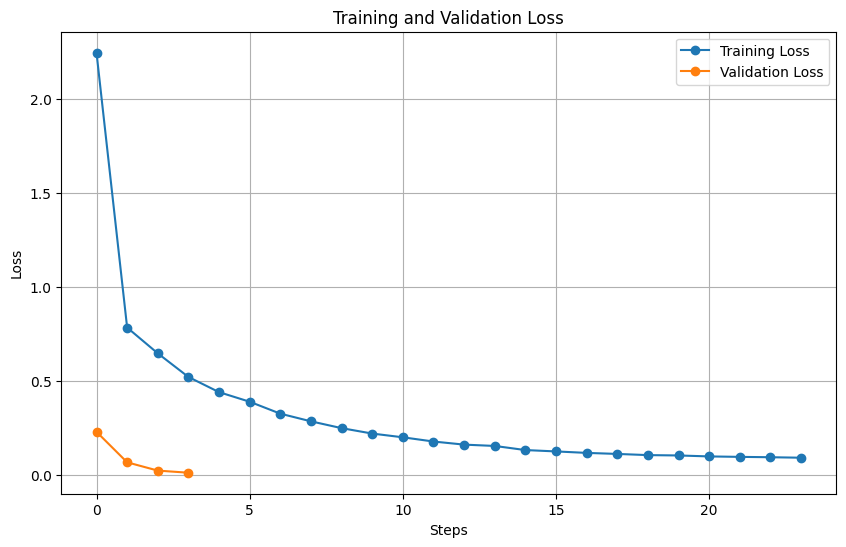

In [9]:
# Prepare steps for training and evaluation losses
train_steps = list(range(len(train_losses)))  # Steps corresponding to training losses
eval_steps = list(range(len(eval_losses)))    # Steps corresponding to evaluation losses

# Plot training and evaluation losses
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label='Training Loss', marker='o')
plt.plot(eval_steps, eval_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
